In [1]:
import numpy as np
import os
import json
import random
import shutil

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
dataset_is_split = False # True if the dataset is already split into training and validation sets

In [3]:
# Load the data annotations
annotations = '/home/enzo.viacava/annotations/instances_default_ev.json'

with open(annotations) as f:
    data = json.load(f)

In [4]:
# Size of the dataset
size = len(data['images'])
print('Number of images in the dataset: ', size)

Number of images in the dataset:  69


In [5]:
# Create the labels (zero is reserved)
labels = {category['id']: category['name'] for category in data['categories']}
print('Labels: ', labels)

Labels:  {1: 'Pieza', 2: 'Biliar', 3: 'Fecal'}


In [6]:
# Specify the paths to the images and annotations (Pascal VOC format)
images_in = '/home/enzo.viacava/jpg/images'
annotations_in = '/home/enzo.viacava/pascal_voc'

In [7]:
# Function to split the dataset into training, validation, and test sets

def split_dataset(images_path, annotations_path, val_split, test_split, out_path):
  """Splits a directory of sorted images/annotations into training, validation, and test sets.

  Args:
    images_path: Path to the directory with your images (JPGs).
    annotations_path: Path to a directory with your VOC XML annotation files,
      with filenames corresponding to image filenames. This may be the same path
      used for images_path.
    val_split: Fraction of data to reserve for validation (float between 0 and 1).
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  Returns:
    The paths for the split images/annotations (train_dir, val_dir, test_dir)
  """
  _, dirs, _ = next(os.walk(images_path))

  train_dir = os.path.join(out_path, 'train')
  val_dir = os.path.join(out_path, 'validation')
  test_dir = os.path.join(out_path, 'test')

  IMAGES_TRAIN_DIR = os.path.join(train_dir, 'images')
  IMAGES_VAL_DIR = os.path.join(val_dir, 'images')
  IMAGES_TEST_DIR = os.path.join(test_dir, 'images')
  os.makedirs(IMAGES_TRAIN_DIR, exist_ok=True)
  os.makedirs(IMAGES_VAL_DIR, exist_ok=True)
  os.makedirs(IMAGES_TEST_DIR, exist_ok=True)

  ANNOT_TRAIN_DIR = os.path.join(train_dir, 'annotations')
  ANNOT_VAL_DIR = os.path.join(val_dir, 'annotations')
  ANNOT_TEST_DIR = os.path.join(test_dir, 'annotations')
  os.makedirs(ANNOT_TRAIN_DIR, exist_ok=True)
  os.makedirs(ANNOT_VAL_DIR, exist_ok=True)
  os.makedirs(ANNOT_TEST_DIR, exist_ok=True)

  # Get all filenames for this dir, filtered by filetype
  filenames = os.listdir(os.path.join(images_path))
  filenames = [os.path.join(images_path, f) for f in filenames if (f.endswith('.jpg'))]
  # Shuffle the files, deterministically
  filenames.sort()
  random.seed(42)
  random.shuffle(filenames)
  # Get exact number of images for validation and test; the rest is for training
  val_count = int(len(filenames) * val_split)
  test_count = int(len(filenames) * test_split)
  for i, file in enumerate(filenames):
    source_dir, filename = os.path.split(file)
    annot_file = os.path.join(annotations_path, filename.replace("jpg", "xml"))
    if i < val_count:
      shutil.copy(file, IMAGES_VAL_DIR)
      shutil.copy(annot_file, ANNOT_VAL_DIR)
    elif i < val_count + test_count:
      shutil.copy(file, IMAGES_TEST_DIR)
      shutil.copy(annot_file, ANNOT_TEST_DIR)
    else:
      shutil.copy(file, IMAGES_TRAIN_DIR)
      shutil.copy(annot_file, ANNOT_TRAIN_DIR)
  return (train_dir, val_dir, test_dir)

In [10]:
# Split the dataset into training, validation, and test sets
train_dir, val_dir, test_dir = split_dataset(images_in, annotations_in,
                                             val_split=0.1, test_split=0,
                                             out_path='split-dataset')

In [11]:
# Create the DataLoader objects for the training, validation, and test sets
train_data = object_detector.DataLoader.from_pascal_voc(
    os.path.join(train_dir, 'images'),
    os.path.join(train_dir, 'annotations'), label_map=labels)
validation_data = object_detector.DataLoader.from_pascal_voc(
    os.path.join(val_dir, 'images'),
    os.path.join(val_dir, 'annotations'), label_map=labels)
test_data = object_detector.DataLoader.from_pascal_voc(
    os.path.join(test_dir, 'images'),
    os.path.join(test_dir, 'annotations'), label_map=labels)
    
print(f'train count: {len(train_data)}')
print(f'validation count: {len(validation_data)}')
print(f'test count: {len(test_data)}')

train count: 63
validation count: 6
test count: 0


In [12]:
# Instantiate the model

# The EfficientDet-Lite models are a family of mobile/IoT-friendly object detection
# models designed for fast deployment and high performance in resource-constrained environments. 
# They are based on the EfficientDet architecture and are optimized for TFLite.
# The models are available in different sizes,
# with the smallest model (Lite0) having the lowest latency and the largest model (Lite4) having the highest accuracy.

# The following EfficientDet-Lite models are available for object detection with TFLite Model Maker:
OBJECT_DETECTION_MODELS = [
    'efficientdet_lite0',
    'efficientdet_lite1',
    'efficientdet_lite2',
    'efficientdet_lite3',
    'efficientdet_lite4',
]
# spec = object_detector.EfficientDetLite0Spec()
spec = model_spec.get(OBJECT_DETECTION_MODELS[0]) # Equivalent to the previous line

# If dataaugmentation is not needed, set it to False
data_augmentation = True
if data_augmentation:
    spec.config.autoaugment_policy = 'v0'

print('Model Spec:', spec.model_name)
print('Auto Augmented Policy:', spec.config.autoaugment_policy)

Model Spec: efficientdet-lite0
Auto Augmented Policy: v0


2024-03-12 08:10:36.082350: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 08:10:40.101457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38421 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-03-12 08:10:40.103727: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38421 MB memory:  -> device: 1, name: A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2024-03-12 08:10:40.107255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 

In [13]:
model = object_detector.create(train_data=train_data, 
                               model_spec=spec, 
                               validation_data=validation_data, 
                               epochs=1000, 
                               batch_size=63, 
                               train_whole_model=True)

Epoch 1/1000


2024-03-12 08:12:18.349756: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301


1/1 [==============================] - 45s 45s/step - det_loss: 2.4677 - cls_loss: 1.1466 - box_loss: 0.0264 - reg_l2_loss: 0.0632 - loss: 2.5309 - learning_rate: 0.0080 - gradient_norm: 1.0883
Epoch 2/1000
1/1 [==============================] - 3s 3s/step - det_loss: 2.3794 - cls_loss: 1.1440 - box_loss: 0.0247 - reg_l2_loss: 0.0632 - loss: 2.4425 - learning_rate: 0.0787 - gradient_norm: 0.8830
Epoch 3/1000
1/1 [==============================] - 4s 4s/step - det_loss: 2.2992 - cls_loss: 1.1265 - box_loss: 0.0235 - reg_l2_loss: 0.0632 - loss: 2.3624 - learning_rate: 0.0787 - gradient_norm: 1.0915
Epoch 4/1000
1/1 [==============================] - 2s 2s/step - det_loss: 2.2044 - cls_loss: 1.0902 - box_loss: 0.0223 - reg_l2_loss: 0.0632 - loss: 2.2676 - learning_rate: 0.0787 - gradient_norm: 0.9724
Epoch 5/1000
1/1 [==============================] - 5s 5s/step - det_loss: 2.0457 - cls_loss: 1.0327 - box_loss: 0.0203 - reg_l2_loss: 0.0632 - loss: 2.1089 - learning_rate: 0.0787 - gradient

In [15]:
model.evaluate(validation_data)

1/1 [==============================] - 5s 5s/step



{'AP': 0.44514853,
 'AP50': 0.669967,
 'AP75': 0.33333334,
 'APs': 0.0,
 'APm': 0.033333335,
 'APl': 0.66722775,
 'ARmax1': 0.44,
 'ARmax10': 0.47703704,
 'ARmax100': 0.47703704,
 'ARs': 0.0,
 'ARm': 0.1,
 'ARl': 0.71,
 'AP_/Pieza': 0.88445544,
 'AP_/Biliar': 0.45,
 'AP_/Fecal': 0.000990099}

In [16]:
TFLITE_FILENAME = 'efficientdet-lite-matadero_epoch_1000_bs_43_ev.tflite'
LABELS_FILENAME = 'matadero_ev.txt'

In [17]:
model.export(export_dir='.', tflite_filename=TFLITE_FILENAME, label_filename=LABELS_FILENAME,
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

2024-03-12 09:52:54.558592: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2024-03-12 09:53:17.197064: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.


Estimated count of arithmetic ops: 1.756 G  ops, equivalently 0.878 G  MACs


2024-03-12 09:53:24.481582: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2024-03-12 09:53:24.481670: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2024-03-12 09:53:24.482753: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpfpd5jhmy
2024-03-12 09:53:24.604636: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2024-03-12 09:53:24.604724: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpfpd5jhmy
2024-03-12 09:53:24.974274: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-03-12 09:53:26.749722: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpfpd5jhmy
2024-03-12 09:53:27.515047: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 3032295

Estimated count of arithmetic ops: 1.756 G  ops, equivalently 0.878 G  MACs


In [18]:
#model.evaluate_tflite(TFLITE_FILENAME, test_data)

In [74]:
test_images_dir = os.path.join(val_dir, "images")
images_path = test_images_dir if dataset_is_split else os.path.join(val_dir, "images")
filenames = os.listdir(os.path.join(images_path))
random_index = random.randint(0,len(filenames)-1)
INPUT_IMAGE = os.path.join(images_path, filenames[random_index])

Image: 2023-12-14_11-27-31-5290.jpg


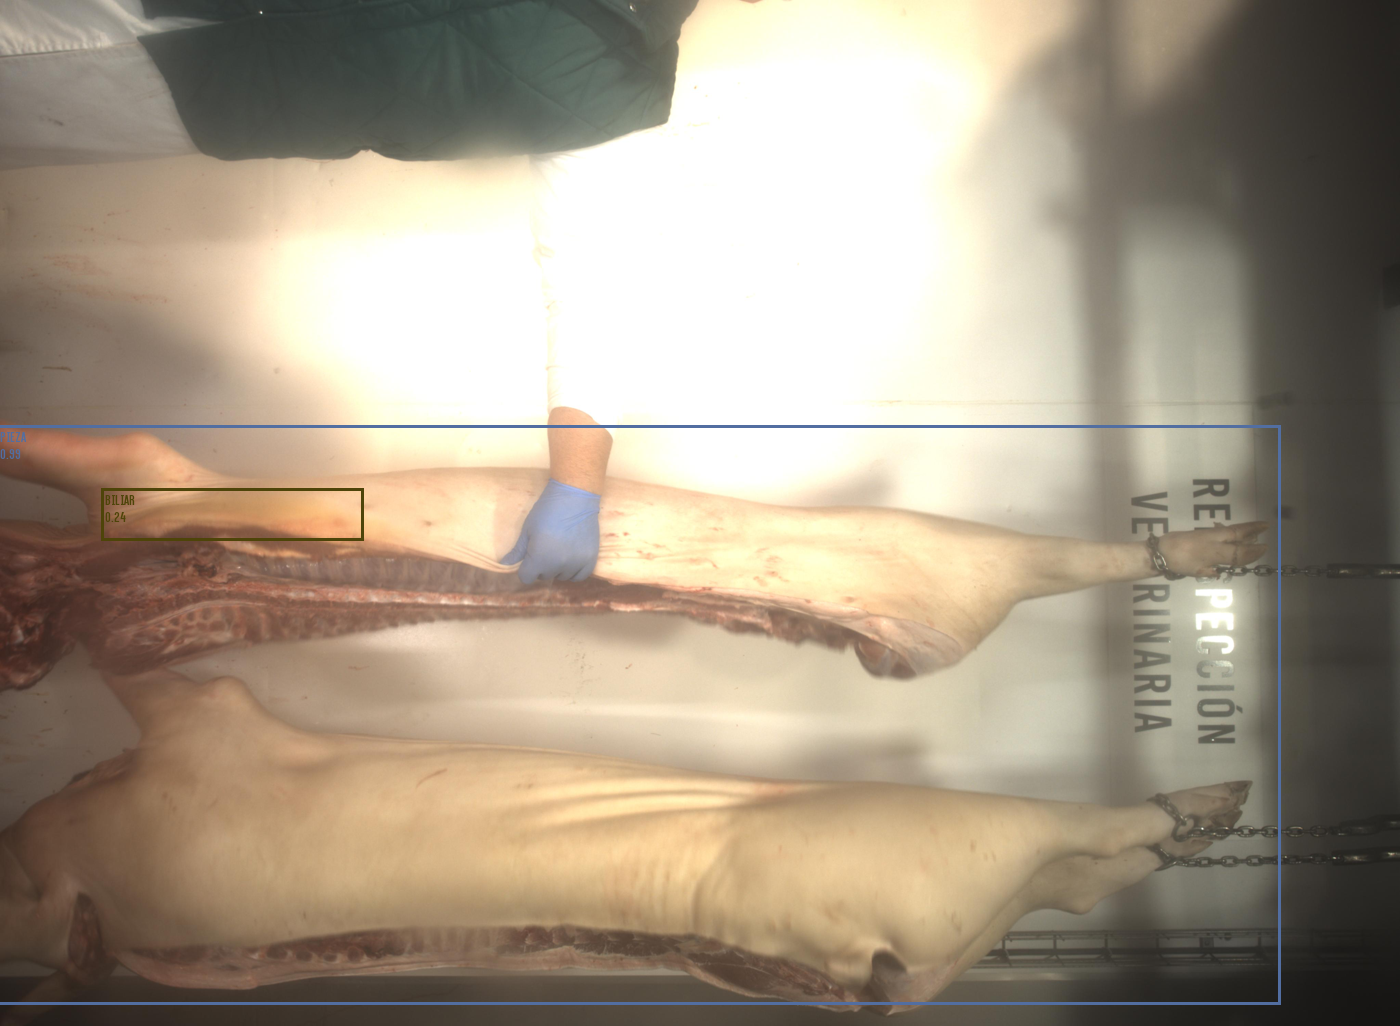

In [75]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import tflite_runtime.interpreter as tflite 
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype=np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline=color, width=3)
    font = ImageFont.truetype("AlegreSans-Regular.ttf", size=15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill=color, font=font)

# Load the TF Lite model
labels = read_label_file(LABELS_FILENAME)
interpreter = tflite.Interpreter(TFLITE_FILENAME)
interpreter.allocate_tensors()

# Resize the image for input
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold=0.2, image_scale=scale)
600
# Resize again to a reasonable size for display
display_width = 1400
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
print('Image:', INPUT_IMAGE.split('/')[-1])
image

In [79]:
# Print the results

for obj in objs:
    print(labels[obj.id], obj.score, obj.bbox)

Pieza 0.98828125 BBox(xmin=-10, ymin=1245, xmax=3742, ymax=2936)
Biliar 0.23828125 BBox(xmin=296, ymin=1429, xmax=1062, ymax=1579)
